<a href="https://colab.research.google.com/github/MachineVisionTeam/SAM/blob/main/SAM_MED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

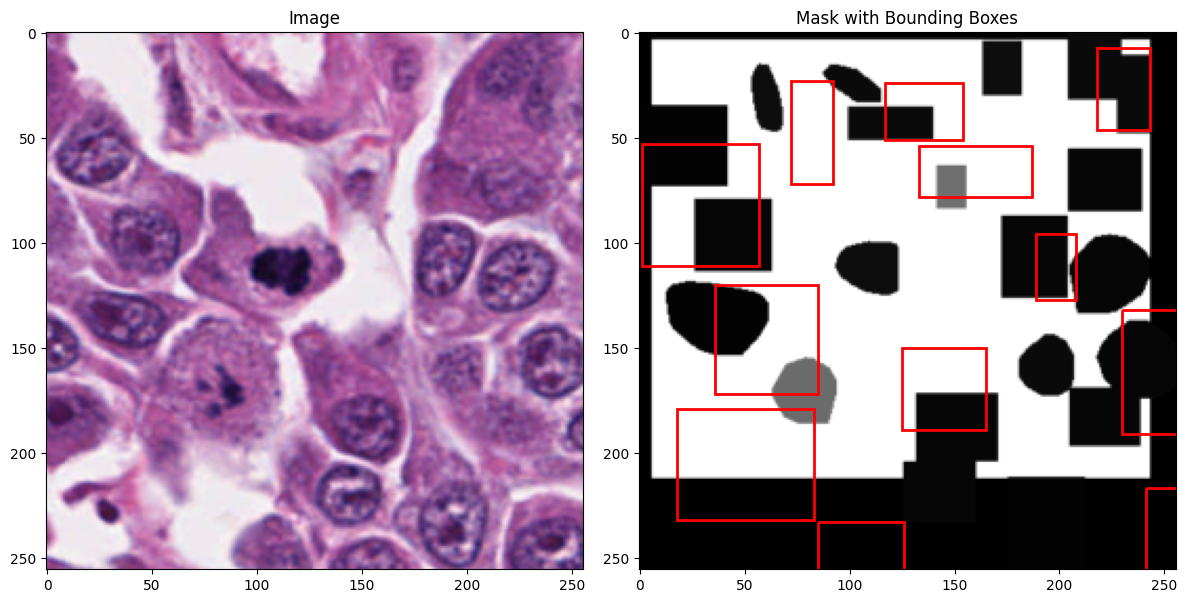

In [ ]:
import os
import cv2
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from transformers import SamProcessor
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Define NuCLS Dataset class
class NuCLSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, annotation_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.annotation_files = annotation_files
        self.transform = transform
        self.annotations = self.load_annotations()

    def load_annotations(self):
        annotations = {}
        for annotation_file in self.annotation_files:
            filename = os.path.splitext(os.path.basename(annotation_file))[0]
            df = pd.read_csv(annotation_file)
            bounding_boxes = []
            for index, row in df.iterrows():
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                bounding_box = [xmin, ymin, xmax, ymax]
                bounding_boxes.append(bounding_box)
            annotations[filename] = bounding_boxes
        return annotations

    def __len__(self):
        return len(self.annotation_files)

    def visualize_data(self, idx):
      item = self[idx]
      image = item["image"].permute(1, 2, 0).numpy()
      mask = item["mask"].squeeze().numpy()
      bounding_boxes = item["bounding_boxes"]

      fig, ax = plt.subplots(1, 2, figsize=(12, 6))

      # Display the image
      ax[0].imshow(image)
      ax[0].set_title("Image")

      # Display the mask with bounding boxes
      ax[1].imshow(mask, cmap="gray")
      ax[1].set_title("Mask with Bounding Boxes")

      # Draw bounding boxes on the mask
      height, width = mask.shape
      for box in bounding_boxes:
          xmin, ymin, xmax, ymax = box
          rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=2)
          ax[1].add_patch(rect)

      plt.tight_layout()
      plt.show()
    def get_bounding_boxes_from_annotation(annotation_path):

      annotation_data = pd.read_csv(annotation_path)
      bounding_boxes = []
      for idx, row in annotation_data.iterrows():
          xmin = row['xmin']
          ymin = row['ymin']
          xmax = row['xmax']
          ymax = row['ymax']
          bounding_boxes.append([xmin, ymin, xmax, ymax])
      return bounding_boxes


    def __getitem__(self, idx):
        annotation_file = self.annotation_files[idx]
        filename = os.path.splitext(os.path.basename(annotation_file))[0]
        image_path = os.path.join(self.image_dir, f"{filename}.png")
        mask_path = os.path.join(self.mask_dir, f"{filename}.png")

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Get bounding boxes from annotations
        bounding_boxes = self.annotations[filename]

        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {"image": image, "mask": mask, "bounding_boxes": bounding_boxes}


# Define SAMProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define paths to image, mask, and annotation directories
image_dir = "/content/drive/MyDrive/Detectron/Detectron/nucleus/images"
mask_dir = "/content/drive/MyDrive/Detectron/Detectron/nucleus/mask"
annotation_dir = "/content/drive/MyDrive/Detectron/Detectron/nucleus/annots"
annotation_files = [os.path.join(annotation_dir, file) for file in os.listdir(annotation_dir) if file.endswith('.csv')]

# Initialize NuCLS dataset with annotation_files instead of annotation_dir
nucls_dataset = NuCLSDataset(image_dir, mask_dir, annotation_files, transform=transform)

# Define function to get bounding box prompt

def get_bounding_boxes_from_annotation(annotation_path):

    annotation_data = pd.read_csv(annotation_path)
    bounding_boxes = []
    for idx, row in annotation_data.iterrows():
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return bounding_boxes





# Define SAMDataset class
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        mask = item["mask"]
        bounding_boxes = item["bounding_boxes"]

        # Prepare image and bounding boxes for the model
        inputs = self.processor(image, input_boxes=[bounding_boxes], return_tensors="pt",do_rescale=False)

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = mask

        return inputs


# Initialize SAM dataset
sam_dataset = SAMDataset(nucls_dataset, processor)

nucls_dataset.visualize_data(3)  # Replace 0 with the desired index


In [ ]:
# Example usage of the get_bounding_boxes_from_annotation function
annotation_path = "/content/drive/MyDrive/Detectron/Detectron/nucleus/annots/TCGA-A2-A0YM-DX1.csv"  # Replace with the actual path to your annotation file
bounding_boxes = get_bounding_boxes_from_annotation(annotation_path)
print("Bounding boxes extracted from annotation file:")
print(bounding_boxes)


Bounding boxes extracted from annotation file:
[[0, 175, 38, 216], [14, 4, 34, 38], [90, 41, 113, 72], [104, 138, 129, 163], [241, 1, 273, 34], [203, 86, 238, 116], [39, 244, 107, 334], [153, 257, 186, 330], [48, 142, 98, 195], [261, 291, 308, 341], [43, 211, 93, 259], [246, 187, 311, 207], [149, 208, 174, 264], [44, 28, 77, 78], [202, 148, 237, 196], [211, 297, 256, 335], [89, 228, 114, 281], [237, 153, 269, 196], [316, 143, 356, 181], [179, 259, 204, 306], [107, 96, 147, 131], [156, 94, 188, 137], [152, 133, 189, 171], [153, 171, 183, 211], [49, 122, 89, 152], [158, 29, 196, 59], [4, 127, 37, 162], [308, 299, 331, 341], [247, 43, 277, 76], [60, 77, 98, 99], [216, 39, 236, 74], [20, 96, 48, 123], [52, 97, 77, 127], [278, 160, 306, 185], [99, 112, 132, 125], [234, 122, 257, 137], [296, 103, 313, 123], [129, 64, 159, 84], [184, 29, 207, 54]]


In [ ]:
print(callable(nucls_dataset.get_bounding_boxes))

True


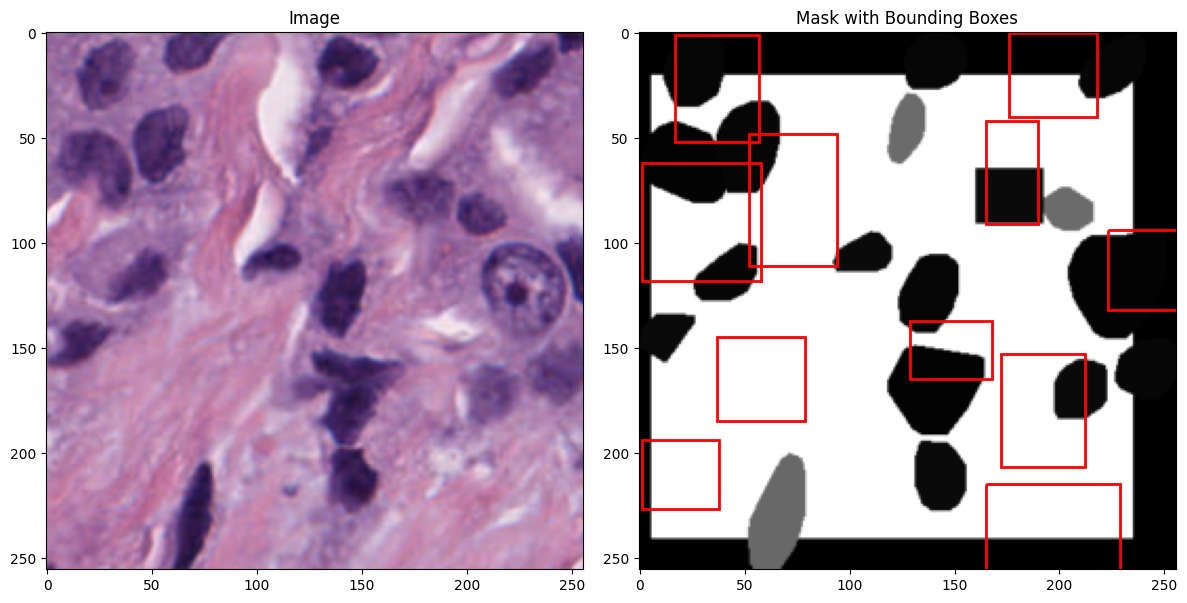

In [ ]:
nucls_dataset.visualize_data(1)  # Replace 0 with the desired index

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
example = sam_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([39, 4])
ground_truth_mask torch.Size([1, 256, 256])


In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.optim import Adam
import torch.nn.functional as F  # Import the functional module


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# Define the loss function
# You can use any other loss function available in PyTorch or MONAI
seg_loss = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
#seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [ ]:
import torch

def collate_fn(batch):
    # Pad or crop input_boxes and ground_truth_mask to a fixed size
    max_boxes = max([len(sample['input_boxes']) for sample in batch])
    padded_input_boxes = [torch.nn.functional.pad(sample['input_boxes'], (0, 0, 0, max_boxes - len(sample['input_boxes'])), mode='constant', value=0) for sample in batch]
    padded_ground_truth_mask = [torch.nn.functional.pad(sample['ground_truth_mask'].unsqueeze(0), (0, 0, 0, 0, 0, max_boxes - sample['ground_truth_mask'].size(0)), mode='constant', value=0) for sample in batch]

    # Create a new batch with padded tensors
    padded_batch = {
        'pixel_values': torch.stack([sample['pixel_values'] for sample in batch]),
        'input_boxes': torch.stack(padded_input_boxes),
        'ground_truth_mask': torch.cat(padded_ground_truth_mask, dim=0)
    }

    return padded_batch

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(sam_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
from tqdm import tqdm
import torch
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"], input_boxes=batch["input_boxes"], multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)

        # Remove the singleton dimension from the predicted masks
        predicted_masks = predicted_masks.squeeze(2)

        ground_truth_masks = batch["ground_truth_mask"].float()

        loss = seg_loss(predicted_masks, ground_truth_masks)

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {mean(epoch_losses)}")


100%|██████████| 4/4 [04:15<00:00, 63.80s/it]

Epoch 1, Loss: 0.09564531967043877


In [ ]:
print("Input tensor shape:", predicted_masks.shape)
print("Target tensor shape:", ground_truth_masks.shape)

Input tensor shape: torch.Size([1, 39, 256, 256])
Target tensor shape: torch.Size([1, 39, 256, 256])


In [ ]:
for batch in train_dataloader:
    print(batch["pixel_values"].shape)
    print(batch["ground_truth_mask"].shape)
    break

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 39, 256, 256])


In [ ]:
import numpy as np
from PIL import Image

example = nucls_dataset[1]

# Extract the image from the example item
image = example["image"]
image


tensor([[[0.5451, 0.5373, 0.5529,  ..., 0.2235, 0.2549, 0.2667],
         [0.5686, 0.5569, 0.5686,  ..., 0.2353, 0.2667, 0.2784],
         [0.5882, 0.5725, 0.5765,  ..., 0.2078, 0.2196, 0.2275],
         ...,
         [0.5412, 0.5176, 0.5333,  ..., 0.9216, 0.9412, 0.9255],
         [0.4588, 0.4353, 0.4392,  ..., 0.9333, 0.9098, 0.8863],
         [0.3608, 0.3569, 0.3647,  ..., 0.9137, 0.8902, 0.8902]],

        [[0.3804, 0.3765, 0.3922,  ..., 0.1137, 0.1216, 0.1255],
         [0.4000, 0.3882, 0.4000,  ..., 0.1137, 0.1216, 0.1294],
         [0.4157, 0.4039, 0.4078,  ..., 0.1020, 0.1098, 0.1137],
         ...,
         [0.3647, 0.3137, 0.3098,  ..., 0.7922, 0.7922, 0.7529],
         [0.2745, 0.2353, 0.2275,  ..., 0.8275, 0.7922, 0.7490],
         [0.2000, 0.1725, 0.1804,  ..., 0.8118, 0.7765, 0.7608]],

        [[0.6235, 0.6275, 0.6235,  ..., 0.2745, 0.2902, 0.3020],
         [0.6314, 0.6314, 0.6235,  ..., 0.2980, 0.3216, 0.3373],
         [0.6235, 0.6157, 0.6078,  ..., 0.3059, 0.3373, 0.

In [ ]:
# Assuming idx is the index of the dataset item
# Assuming idx is the index of the dataset item
idx=1
annotation_file = annotation_files[idx]
prompt = get_bounding_boxes_from_annotation(annotation_file)

# Prepare image + box prompt for the model
inputs = processor(nucls_dataset[idx]["image"], input_boxes=[prompt], return_tensors="pt")


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [ ]:
for k, v in inputs.items():
    print(k, v.shape)


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 18, 4])


In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

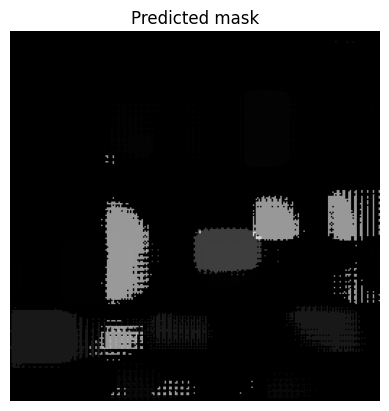

In [ ]:
def show_mask(masks, ax, random_color=False):
    if random_color:
        color = np.random.random((len(masks), 3))
    else:
        color = np.array([[30/255, 144/255, 255/255]] * len(masks))
    for i, mask in enumerate(masks):
        ax.imshow(mask, alpha=0.6, cmap='gray')


fig, axes = plt.subplots()

# Convert the image tensor to a numpy array and transpose it to shape (H, W, C)
image_np = np.transpose(image.numpy(), (1, 2, 0))

axes.imshow(image_np)
show_mask(medsam_seg, axes)
axes.set_title("Predicted mask")
axes.axis("off")

Visualization saved at: /content/drive/MyDrive/Detectron/Output/visualization_1.png


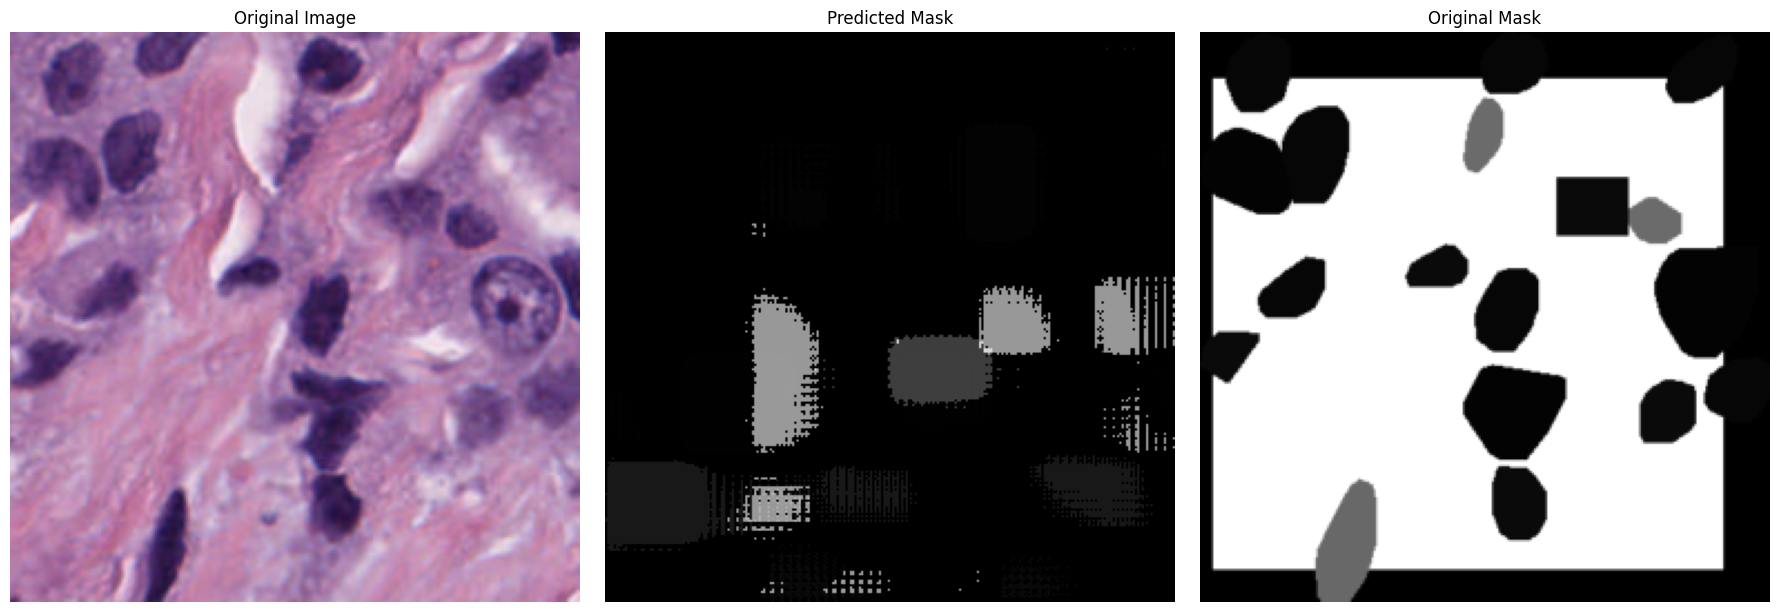

In [ ]:
def show_mask(masks, ax, random_color=False):
    if random_color:
        color = np.random.random((len(masks), 3))
    else:
        color = np.array([[30/255, 144/255, 255/255]] * len(masks))
    for i, mask in enumerate(masks):
        ax.imshow(mask, alpha=0.6, cmap='gray')

save_dir = "/content/drive/MyDrive/Detectron/Output"
os.makedirs(save_dir, exist_ok=True)
# Get the sample from the dataset
sample_index = 1  # Change this to the index of the sample you want to visualize
data = nucls_dataset[sample_index]

# Convert the image tensor to a numpy array and transpose it to shape (H, W, C)
image_np = np.transpose(data["image"].numpy(), (1, 2, 0))

# Display the original image
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

# Display the predicted mask
plt.subplot(1, 3, 2)
show_mask(medsam_seg, plt)
plt.title("Predicted Mask")
plt.axis("off")

# Display the original mask
plt.subplot(1, 3, 3)
original_mask = data['mask'].squeeze().numpy()
plt.imshow(original_mask, cmap='gray')
plt.title("Original Mask")
plt.axis("off")

plt.tight_layout()

save_path = os.path.join(save_dir, f"visualization_{sample_index}.png")
plt.savefig(save_path)

# Show a message indicating where the visualization is saved
print(f"Visualization saved at: {save_path}")


In [ ]:
print(image.shape)

torch.Size([1, 3, 1024, 1024])


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [77]:
def calculate_iou(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask).sum()
    union = np.logical_or(predicted_mask, target_mask).sum()
    iou = intersection / union
    return iou

def calculate_precision_recall_f1(predicted_mask, target_mask):
    tp = np.logical_and(predicted_mask, target_mask).sum()
    fp = np.logical_and(predicted_mask, np.logical_not(target_mask)).sum()
    fn = np.logical_and(np.logical_not(predicted_mask), target_mask).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score


sample_index = 1
data = nucls_dataset[sample_index]


predicted_mask = medsam_seg


target_mask = data['mask'].squeeze().numpy()


iou = calculate_iou(predicted_mask, target_mask)
precision, recall, f1_score = calculate_precision_recall_f1(predicted_mask, target_mask)


print("IoU:", iou)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

IoU: 0.1008899739300566
Precision: 0.8766752973186466
Recall: 0.10234247083438357
F1 Score: 0.1832880239064953
